In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

import random
import string
import seaborn as sns
import os
import numpy as np
import timeit

In [2]:
model_logs_root = '/Users/rohan/Documents/python-projects/deepracer/2022-October/Logs-Milestone-Every2-NoCrash-10Hours'
log = DeepRacerLog(model_logs_root)

# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()

{'network': 'DEEP_CONVOLUTIONAL_NETWORK_SHALLOW',
 'sensor_list': ['FRONT_FACING_CAMERA'],
 'simapp_version': '4'}
-------------
{'batch_size': 64,
 'beta_entropy': 0.01,
 'discount_factor': 0.999,
 'e_greedy_value': 0.05,
 'epsilon_steps': 10000,
 'exploration_type': 'categorical',
 'loss_type': 'huber',
 'lr': 0.0003,
 'num_episodes_between_training': 20,
 'num_epochs': 10,
 'stack_size': 1,
 'term_cond_avg_score': 350000000.0,
 'term_cond_max_episodes': 1000000000}
-------------
{'speed': {'high': 1.0, 'low': 0.5},
 'steering_angle': {'high': 30.0, 'low': -30.0}}


In [3]:
track_path = "/Users/rohan/Documents/python-projects/deepracer/deepracer-k1999-race-lines/tracks/"
ListFiles = [f for f in os.listdir(track_path) if os.path.isfile(os.path.join(track_path, f))]
print(ListFiles)

['reInvent2019_track.npy', '2022_august_open.npy', 'Canada_Training.npy', 'canada_race.npy', 'Tokyo_Training_track.npy', 'Oval_track.npy', 'New_York_Track.npy', 'Bowtie_track.npy', 'H_track.npy', 'reinvent_base.npy', '2022_september_open.npy', 'Mexico_track.npy', 'Virtual_May19_Train_track.npy', 'Straight_track.npy', 'AWS_track.npy', 'China_track.npy', '2022_july_open.npy', '2022_june_open.npy', 'London_Loop_Train.npy']


In [4]:
def get_track_waypoints(track_name):
    return np.load("%s/%s.npy" % (track_path, track_name))

trackname="2022_september_open"
waypoints = get_track_waypoints(trackname)
waypoints.shape

(152, 6)

In [5]:
center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

In [6]:
def plot_track(ax):
    ax.plot(inner_border[:, 0], inner_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(outer_border[:, 0], outer_border[:, 1], '.', color='#646464', zorder=1)
    ax.plot(inner_border[:, 0], inner_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    ax.plot(outer_border[:, 0], outer_border[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

In [17]:
episode_num = 598
custom_df = df[df['episode'] == episode_num]
start= custom_df.index[0]

step = 4
speed = np.zeros(len(custom_df))
x_coords = np.zeros(len(custom_df))
y_coords = np.zeros(len(custom_df))
idx = 0

for ep in custom_df['episode'].unique():
    prv = np.roll(custom_df.index[custom_df['episode'] == ep], 1) - start
    cur = np.roll(custom_df.index[custom_df['episode'] == ep], 0) - start
    if custom_df.iloc[prv[0]]['progress'] == 100:
        for i in range(step, len(cur) - step, step):
            speed[idx] = custom_df.iloc[cur[i] - step:cur[i] + step + 1]['speed'].mean()
            x_coords[idx] = custom_df.iloc[cur[i]]['x']
            y_coords[idx] = custom_df.iloc[cur[i]]['y']
            idx += 1

0.616494245732408
0.9498074349668058
0.8053755095014605
0.5
1.0
0.8058881663010307


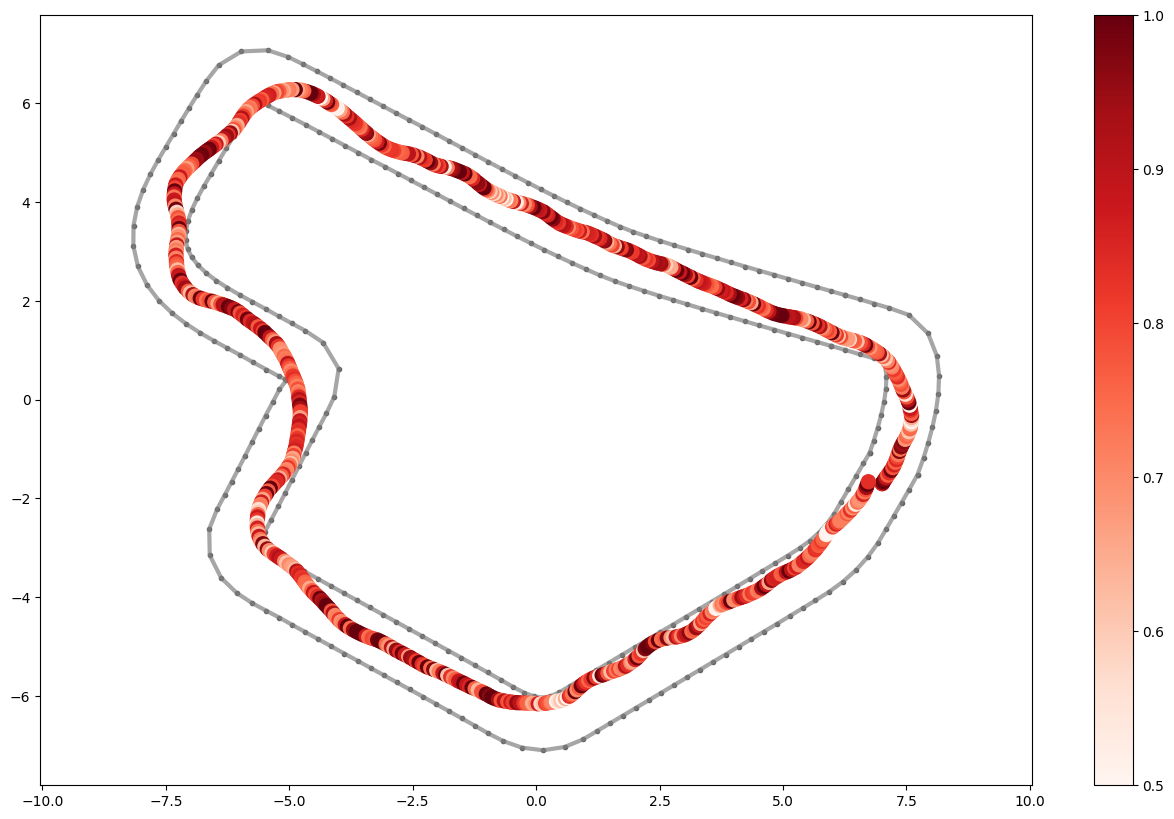

In [18]:
print(speed[:idx].min())
print(speed[:idx].max())
print(speed[:idx].mean())
print(custom_df['speed'].min())
print(custom_df['speed'].max())
print(custom_df['speed'].mean())

fig = plt.figure(2, figsize=(16, 10))
ax = fig.add_subplot(111)
plt.axis('equal')
plot_track(ax)
# scatter = ax.scatter(
#     x_coords[:idx], y_coords[:idx], s=100,
#     c=speed[:idx], cmap='Reds', zorder=3
# )
scatter = ax.scatter(
    custom_df['x'], custom_df['y'], s=100,
    c=custom_df['speed'], cmap='Reds', zorder=3
)
fig.colorbar(scatter)

In [10]:
from numpy import array

fname = '../deepracer-k1999-race-lines/speeds/2022_september_open-0-5-2022-10-23-150151.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
optimal_speeds = deserialized
optimal_speeds.shape

(151,)

In [11]:
from numpy import array

fname = '../deepracer-k1999-race-lines/racelines/2022_september_open-2000-4-2022-10-23-145109.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
racing_line = deserialized
racing_line.shape

(152, 2)

In [12]:
def plot_racing_line(ax, zdot=1, zline=2):
    ax.plot(racing_line[:, 0], racing_line[:, 1], '.', color='#646464', zorder=zdot)
    ax.plot(racing_line[:, 0], racing_line[:, 1], color='gray', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=zline)

In [13]:
npoints = len(racing_line) - 1

In [19]:
def gen_graph_data(episode_num):
    custom_df = df[df['episode'] == episode_num]
    start= custom_df.index[0]

    step = 4
    speed_diff = np.zeros(len(custom_df))
    x_coords = np.zeros(len(custom_df))
    y_coords = np.zeros(len(custom_df))
    idx = 0

    for ep in custom_df['episode'].unique():
        prv = np.roll(custom_df.index[custom_df['episode'] == ep], 1) - start
        cur = np.roll(custom_df.index[custom_df['episode'] == ep], 0) - start
        nxt = np.roll(custom_df.index[custom_df['episode'] == ep], -1) - start
        if custom_df.iloc[prv[0]]['progress'] == 100:
            for i in range(step, len(cur) - step, step):
                coords = custom_df.iloc[cur[i] - step:cur[i] + step + 1][['x', 'y']].to_numpy()
                distances_to_waypoints = np.hypot(racing_line[:npoints, 0:1].T - coords[:, 0:1], racing_line[:npoints, 1:2].T - coords[:, 1:2])
                closest_waypoints = np.argmin(distances_to_waypoints, axis=1)
                speeds = custom_df.iloc[cur[i] - step:cur[i] + step + 1]['speed']
                speed_optimals = optimal_speeds[closest_waypoints]
                speed_diff[idx] = np.mean(speeds - speed_optimals)
                x_coords[idx] = custom_df.iloc[cur[i]]['x']
                y_coords[idx] = custom_df.iloc[cur[i]]['y']
                idx += 1
    return idx, speed_diff, x_coords, y_coords

-0.16758480842775425
-0.1768461859161383


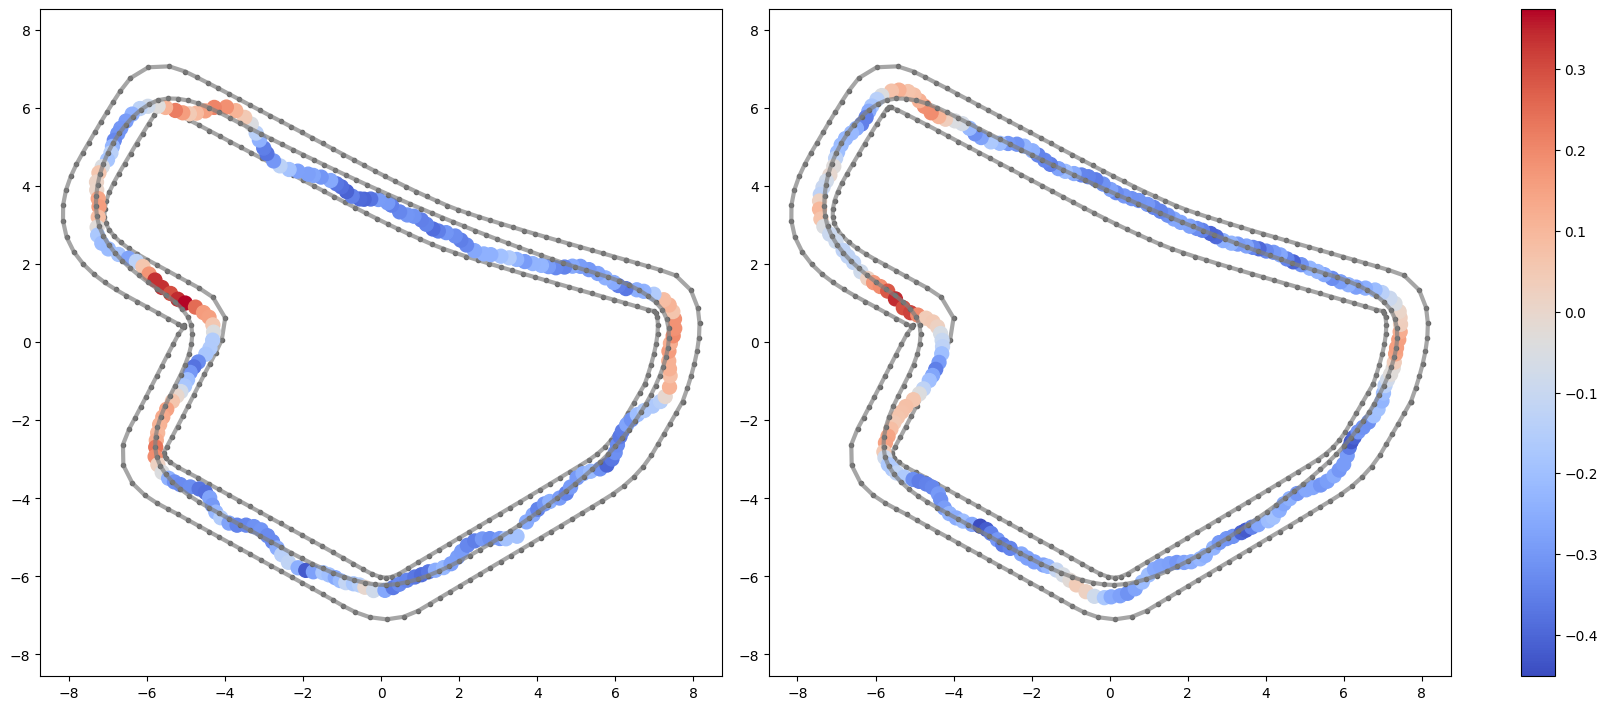

In [21]:
# print(speed_diff[:idx].min())
# print(speed_diff[:idx].max())
# print(speed_diff[:idx].mean())

# fig = plt.figure(2, figsize=(16, 10))
# ax = fig.add_subplot(111)
# plt.axis('equal')
# plot_track(ax)
# scatter = ax.scatter(
#     x_coords[:idx], y_coords[:idx], s=100,
#     c=speed_diff[:idx], cmap='coolwarm', zorder=3
# )
# plot_racing_line(ax, 4, 5)
# fig.colorbar(scatter)

episodes = [236, 473]
idx = [None, None]
speed_diff = [None, None]
x_coords = [None, None]
y_coords = [None, None]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7), layout='constrained')
vmin = None
vmax = None

for i in range(axes.size):
    idx[i], speed_diff[i], x_coords[i], y_coords[i] = gen_graph_data(episodes[i])
    vmin = speed_diff[i][:idx[i]].min() if not vmin else min(speed_diff[i][:idx[i]].min(), vmin)
    vmax = speed_diff[i][:idx[i]].max() if not vmax else max(speed_diff[i][:idx[i]].max(), vmax)

for i, ax in enumerate(axes.flat):
    print(speed_diff[i][:idx[i]].mean())
    ax.axis('equal')
    plot_track(ax)
    scatter = ax.scatter(
        x_coords[i][:idx[i]], y_coords[i][:idx[i]], s=100,
        c=speed_diff[i][:idx[i]], cmap='coolwarm', zorder=3,
        vmin=vmin, vmax=vmax
    )
    plot_racing_line(ax, 4, 5)

fig.colorbar(scatter, ax=axes)